Adapted from methods in dynamic-vision pipeline.

https://github.com/cajal/dynamic-vision/blob/7ab1ae8530a7681645b4f56766b6359cbb6fc0b3/scans/scan.py#L529

In [19]:
import math
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.signal import CenteredSpline

import datajoint as dj
from pipeline import meso
from stimulus import stimulus
stats = dj.create_virtual_module('neurodata_static_stats', 'neurodata_static_stats')


In [2]:
scan_key  = {'animal_id': 21067, 'session': 10, 'scan_idx': 18} 
max_distance = 80 # microns
min_correlation = 0.9

In [ ]:
# restrict to masks classified as soma
soma = (meso.ScanSet.Unit & scan_key & (meso.MaskClassification.Type() & dict(type="soma"))).proj()

# get the activity traces, unit positions, field membership, ms_delays
fetch_strs = ['KEY','um_x','um_y','um_z','ms_delay','trace','field','pearson']
joint_rel = meso.ScanSet.UnitInfo * meso.Activity.Trace * soma * stats.Oracle.UnitScores
unit_keys,xs,ys,zs,ms_delays,traces,fields,oracles = joint_rel.fetch(*fetch_strs)
delays = ms_delays / 1000 # correct from ms to s

positions = np.stack([xs, ys, zs], 1)

df = pd.DataFrame(unit_keys)
df['oracle'] = oracles
df['position'] = list(map(np.array,positions))

In [4]:
# downsample from scan depth times (nframes * ndepths) to scan frame times 
ndepth = len(dj.U('z') & (meso.ScanInfo.Field & scan_key))
frame_times = (stimulus.Sync & scan_key).fetch1("frame_times").squeeze()[::ndepth]

In [5]:
# create hanning filter for desired downsample frequency
unique_hz = 1
source_hz = 1/ np.nanmedian(np.diff(frame_times))

M = 2*round(source_hz/unique_hz)+1
n = np.arange(M)    
h = 0.5 - 0.5 * np.cos(2.0 * np.pi * n / (M - 1))
h /= h.sum()

#  apply low pass filter to traces
traces = [np.convolve(t,h,mode='same') for t in traces]



In [6]:
# Clip scan times and spikes to the same length
assert abs(len(frame_times) - len(traces[0])) < 2, "length of times differs from spikes by more than 1"
min_length = min(len(frame_times), len(traces[0]))
frame_times = frame_times[:min_length]
traces = [t[:min_length] for t in traces]


In [10]:
# Sample at specified hz
scan_start = frame_times[0] + delays.max()
n_samples = math.floor((frame_times[-1] - scan_start) * unique_hz)
sample_times = scan_start + np.arange(n_samples) / unique_hz

traces = np.stack(
    [
        CenteredSpline(frame_times + d, f)(sample_times)
        for d, f in zip(delays, traces)
    ],
    0,
)
norm_traces = (traces - traces.mean(-1, keepdims=True)) / (traces.std(-1, keepdims=True) + 1e-8)
df['norm_trace'] = list(map(np.array,norm_traces))

In [11]:
# Undirected graph
G = nx.Graph()
G.add_nodes_from(range(len(traces)))
for node, (norm_trace, position) in enumerate(zip(norm_traces, positions)):
    # distance threshold
    distances = np.linalg.norm(position[None] - positions, 2, 1)
    distance_idx = np.nonzero(distances < max_distance)[0]

    # correlation threshold
    corrs = (norm_trace[None] * norm_traces[distance_idx]).mean(-1)
    corr_idx = np.nonzero(corrs > min_correlation)[0]

    # add edges
    G.add_edges_from([(node, n) for n in distance_idx[corr_idx].tolist()])

In [172]:
# select representative unit from that group using max oracle
neuron_keys = []
rep_units = []
unit_keys = []
distances = []
corrs = []
for neuron_id, node_set in enumerate(nx.connected_components(G)):
    _df = df.loc[list(node_set)]
    unit_id = _df.loc[_df["oracle"].idxmax(), "unit_id"]
    neuron_keys += [dict(neuron_id=neuron_id, unit_id=unit_id)]
    rep_units += [unit_id]
    unit_keys += [dict(neuron_id=neuron_id, unit_id=uid) for uid in _df.unit_id]
    if len(_df)>1:
        com = np.mean(np.vstack(_df['position']),axis=0)
        distances.append(np.linalg.norm(com - np.vstack(_df['position']),2,1))
        corrs.append(np.vstack((np.array(_df.loc[_df['unit_id']==unit_id,'norm_trace']) * 
                                np.array(_df.loc[_df['unit_id']!=unit_id,'norm_trace']))).mean(-1))


(array([0.00e+00, 2.75e+03, 6.10e+02, 5.00e+02, 3.43e+02, 2.49e+02,
        2.00e+01, 4.00e+00, 3.00e+00, 2.00e+00]),
 array([-0.5,  0.6,  1.7,  2.8,  3.9,  5. ,  6.1,  7.2,  8.3,  9.4, 10.5]),
 <BarContainer object of 10 artists>)

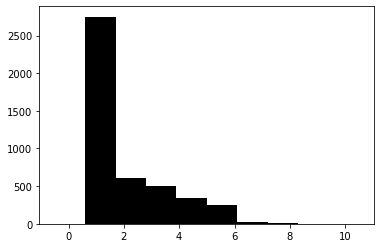

In [49]:
plt.hist([len(x) for x in nx.connected_components(G)],bins = np.linspace(-0.5,10.5,11),color='k')

(array([6.060e+02, 9.600e+01, 1.985e+03, 5.300e+01, 0.000e+00, 1.412e+03,
        1.000e+01, 7.860e+02, 4.400e+01, 2.000e+00, 4.070e+02, 5.000e+00,
        1.270e+02, 1.900e+01, 0.000e+00, 4.800e+01, 0.000e+00, 8.000e+00,
        4.000e+00, 0.000e+00, 6.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

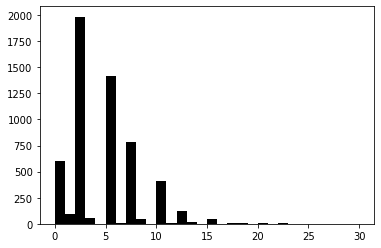

In [240]:
plt.hist(np.concatenate(distances),bins=np.linspace(0,30,31),color='k')

In [209]:
rep_traces = df.loc[[u in rep_units for u in df['unit_id']],'norm_trace']
rep_corrs = []
for i in tqdm(np.arange(len(rep_traces)-1)):
    
    rep_corrs.append((np.vstack(rep_traces)[i][None] * 
                       np.vstack(rep_traces)[i+1:][None]).mean(-1))


100%|██████████| 4480/4480 [13:03<00:00,  5.72it/s]


In [236]:
field_corrs = []

for field in np.arange(10)+1:
    field_traces = df.loc[df['field'] == field,'norm_trace']
    for i in tqdm(np.arange(len(field_traces)-1)):

        field_corrs.append((np.vstack(field_traces)[i][None] * 
                           np.vstack(field_traces)[i+1:][None]).mean(-1))


100%|██████████| 830/830 [00:23<00:00, 35.95it/s]


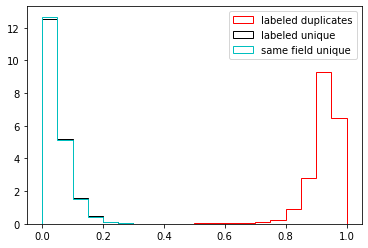

In [239]:
bins = np.linspace(0,1,21)
plt.hist(np.concatenate(corrs),bins=bins,color='r',histtype=u'step',
         density=True,label='labeled duplicates')
plt.hist(np.hstack(rep_corrs).squeeze(),bins=bins,color='k',histtype=u'step',
         density=True, label='labeled unique')
plt.hist(np.hstack(field_corrs).squeeze(),bins=bins,color='c',histtype=u'step',
         density=True, label='same field unique')
_ = plt.legend()